## Mining of Massive Datasets - Zeljko Stojkovic 2021230319

# Project Objective:

League of Legends (LoL) is a highly popular multiplayer online battle arena (MOBA) video game developed and published by Riot Games. In this game, players control unique "champions" with special abilities and battle against other players or computer-controlled champions to destroy the opposing team's "nexus," a structure located at the heart of their base.

The most popular game mode in LoL is Summoner's Rift, where two teams of five players compete to advance waves of minions along three lanes (top, middle, and bottom) to destroy enemy structures and ultimately the opposing team's nexus. The map is divided by a river, with neutral areas known as the "jungle" in four quadrants.

Throughout the game, players aim to destroy enemy structures:

- Towers: 11 defensive structures called turrets or towers guard each team's lanes.
- Inhibitor: Each lane contains one Inhibitor that can be attacked after destroying the three turrets in that lane.
- Elemental Drakes/Elder Dragon: Powerful monsters in the river that grant buffs to the team that kills them.
- Rift Herald: A powerful enemy in the upper river that can be summoned to attack enemy towers.
- Baron Nashor: The most powerful neutral enemy, located in the upper river, which spawns after 20 minutes.
- Nexus: The main structure of each team, which can only be damaged once all turrets and the inhibitor in a lane are destroyed. Destroying the enemy Nexus wins the game.

**The objective of this project is to analyze a dataset containing information about various League of Legends matches, including details such as game duration, first blood, first tower destruction, first inhibitor destruction, first Baron kill, first Dragon kill, and first Rift Herald kill. By examining these factors and their relationships, we aim to identify patterns and strategies that contribute to a team's victory.**


# Dataset

The dataset used in this project contains information about **51.490** League of Legends matches. 
- link: https://www.kaggle.com/datasets/datasnaek/league-of-legends/code
The dataset includes the following fileds:

- Winner: Indicates which team won the match (1 = team1, 2 = team2)
- First Blood: Indicates which team drew the first blood (1 = team1, 2 = team2, 0 = none)
- First Tower: Indicates which team destroyed the first tower (1 = team1, 2 = team2, 0 = none)
- First Inhibitor: Indicates which team destroyed the first inhibitor (1 = team1, 2 = team2, 0 = none)
- First Baron: Indicates which team killed the first Baron Nashor (1 = team1, 2 = team2, 0 = none)
- First Dragon: Indicates which team killed the first Dragon (1 = team1, 2 = team2, 0 = none)
- First Rift Herald: Indicates which team killed the first Rift Herald (1 = team1, 2 = team2, 0 = none)
- Tower Kills: The number of towers each team destroyed (t1_towerKills, t2_towerKills)
- Inhibitor Kills: The number of inhibitors each team destroyed (t1_inhibitorKills, t2_inhibitorKills)
- Baron Kills: The number of Baron Nashors each team killed (t1_baronKills, t2_baronKills)
- Dragon Kills: The number of Dragons each team killed (t1_dragonKills, t2_dragonKills)

The dataset also include other information such as:

- Game Duration: The length of the match
- Champion IDs: Identifiers of the champions used by each player in match (name of champion can be found in champion.csv)
- Summonr Spell IDs: Identifiers of the summoner spells used by each player (name of spell can be found in summoner_spell.csv)
- Ban Information: The champions banned by each team during the pick/ban phase

#### Exploratory Data Analysis (EDA):

#### Loading the dataset:
Before we can start, we must first import the required libraries and modules which will be used for this EDA, as well as import the dataset.

In [2]:
import pandas as pd, numpy as np, os, json
import matplotlib.pyplot as plt 
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, avg, countDistinct
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

##### In this project, we are working with files containing information about Lol champions, summoner spells. The files are initially in JSON for the puropse of our analysis, we will conver these JSON files to CSV

In [3]:
summoner_spell_file = 'data/summoner_spell_info.json'
champion_info_file = 'data/champion_info.json'
champion_type_file = 'data/champion_info_2.json'
games_file = 'data/games.csv'

summoner_spell_json = pd.read_json(summoner_spell_file)
champion_info_json = pd.read_json(champion_info_file)
champion_type_json = pd.read_json(champion_type_file)

#### 1. Analyzing the dataset:
The next step will be general analysis of the dataset.

In [4]:
summoner_sepll = pd.json_normalize(summoner_spell_json['data'])
summoner_sepll.head()

,id,summonerLevel,name,key,description
0,1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
1,3,4,Exhaust,SummonerExhaust,"Exhausts target enemy champion, reducing their..."
2,4,8,Flash,SummonerFlash,Teleports your champion a short distance towar...
3,6,1,Ghost,SummonerHaste,Your champion gains increased Movement Speed a...
4,7,1,Heal,SummonerHeal,Restores 90-345 Health (depending on champion ...


In [5]:
champion_info = pd.json_normalize(champion_info_json['data'])
champion_info.head()

,title,id,key,name
0,the Dark Child,1,Annie,Annie
1,the Berserker,2,Olaf,Olaf
2,the Colossus,3,Galio,Galio
3,the Card Master,4,TwistedFate,Twisted Fate
4,the Seneschal of Demacia,5,XinZhao,Xin Zhao


In [6]:
champion_type = pd.json_normalize(champion_type_json['data'])
champion_type.head()

,tags,title,id,key,name
0,[],None,-1,None,None
1,"[Fighter, Tank]",the Monkey King,62,MonkeyKing,Wukong
2,"[Fighter, Assassin]",Grandmaster at Arms,24,Jax,Jax
3,"[Mage, Support]",the Harbinger of Doom,9,Fiddlesticks,Fiddlesticks
4,[Assassin],the Demon Jester,35,Shaco,Shaco


In [7]:
def json_to_csv(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data['data'], orient='index')
    
    if 'tags' in df.columns:
        df['tags'] = df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
 
    csv_file = os.path.splitext(json_file)[0] + '.csv'
    
    df.to_csv(csv_file, index=False)

In [8]:
json_files = ['data/summoner_spell_info.json', 'data/champion_info.json', 'data/champion_info_2.json']

for json_file in json_files:
    json_to_csv(json_file)

summoner_spell_file = 'data/summoner_spell_info.csv'
champion_info_file = 'data/champion_info.csv'
champion_type_file = 'data/champion_info_2.csv'

In [9]:
spark = SparkSession.builder \
                    .appName("league-of-legends-game-prediction") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()
spark

24/09/11 14:00:54 WARN Utils: Your hostname, zstojkovic00 resolves to a loopback address: 127.0.1.1; using 192.168.1.72 instead (on interface enp5s0)
24/09/11 14:00:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/11 14:00:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/11 14:00:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/11 14:00:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/11 14:00:55 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [10]:
games = spark.read.csv(games_file, header=True, inferSchema=True) 
summoner_spell = spark.read.csv(summoner_spell_file, header=True)
champion = spark.read.csv(champion_info_file, header=True)
champion_type = spark.read.csv(champion_type_file, header=True)

In [11]:
games.printSchema()
print(games.count())
print(games.rdd.getNumPartitions())

root
 |-- gameId: long (nullable = true)
 |-- creationTime: long (nullable = true)
 |-- gameDuration: integer (nullable = true)
 |-- seasonId: integer (nullable = true)
 |-- winner: integer (nullable = true)
 |-- firstBlood: integer (nullable = true)
 |-- firstTower: integer (nullable = true)
 |-- firstInhibitor: integer (nullable = true)
 |-- firstBaron: integer (nullable = true)
 |-- firstDragon: integer (nullable = true)
 |-- firstRiftHerald: integer (nullable = true)
 |-- t1_champ1id: integer (nullable = true)
 |-- t1_champ1_sum1: integer (nullable = true)
 |-- t1_champ1_sum2: integer (nullable = true)
 |-- t1_champ2id: integer (nullable = true)
 |-- t1_champ2_sum1: integer (nullable = true)
 |-- t1_champ2_sum2: integer (nullable = true)
 |-- t1_champ3id: integer (nullable = true)
 |-- t1_champ3_sum1: integer (nullable = true)
 |-- t1_champ3_sum2: integer (nullable = true)
 |-- t1_champ4id: integer (nullable = true)
 |-- t1_champ4_sum1: integer (nullable = true)
 |-- t1_champ4_sum2

In [12]:
# Check nulls in each column
null_counts = games.select([sum(col(c).isNull().cast("int")).alias(c) for c in games.columns])
null_counts.show()

24/09/11 14:01:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|gameId|creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ2_sum2|t1_

##### As we can see, there are no missing values in this dataset. 

In [13]:
# Checks unique values in each column
unique_counts = games.select([countDistinct(col(c)).alias(c) for c in games.columns])
unique_counts.show()

+------+------------+------------+--------+------+----------+----------+--------------+----------+-----------+---------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-----------+--------------+--------------+-------------+-----------------+-------------+--------------+------------------+-------+-------+-------+-------+-------+
|gameId|creationTime|gameDuration|seasonId|winner|firstBlood|firstTower|firstInhibitor|firstBaron|firstDragon|firstRiftHerald|t1_champ1id|t1_champ1_sum1|t1_champ1_sum2|t1_champ2id|t1_champ2_sum1|t1_champ2_sum2|t1_

#### 1.1. Data Visualization

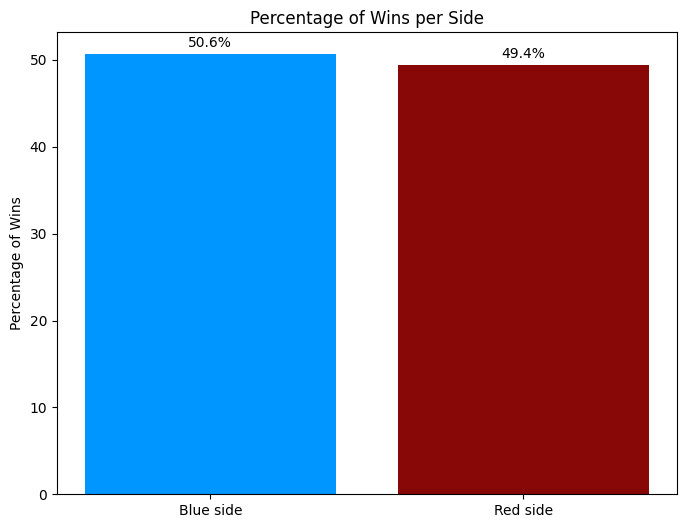

In [14]:
# group wins per side and count winner
side_wins = games.groupBy("winner").count()

# total_wins
total_wins = side_wins.agg(sum("count").alias("total_wins")).collect()[0]["total_wins"]

# calculate win percentage per side
side_wins = side_wins.withColumn("percentage", (col("count") / total_wins) * 100)


side_wins_pandas = side_wins.toPandas()

plt.figure(figsize=(8, 6))
colors = ['#0096FF', '#880808']
bars = plt.bar(side_wins_pandas["winner"], side_wins_pandas["percentage"], color=colors)
plt.title("Percentage of Wins per Side")
plt.ylabel("Percentage of Wins")
plt.xticks(ticks=[1, 2], labels=["Blue side", "Red side"])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', 
             ha='center', va='bottom')

plt.show()


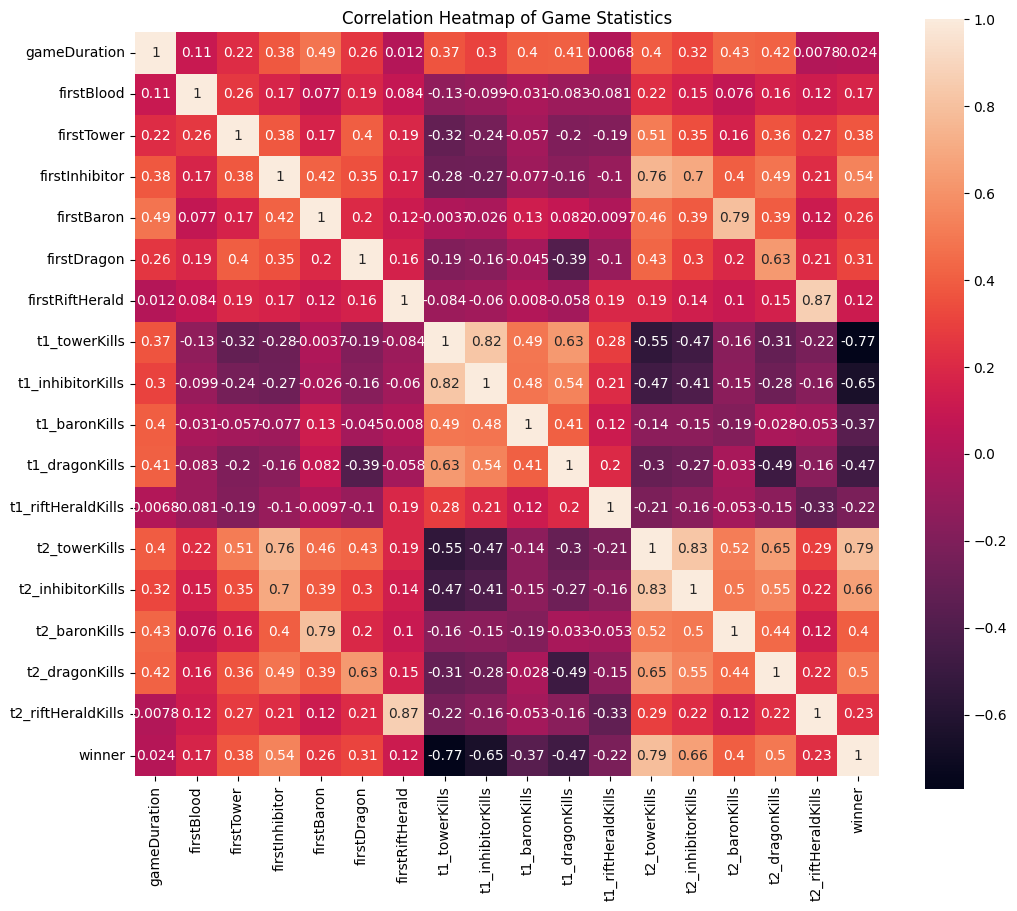

In [15]:
features = ["gameDuration", "firstBlood", "firstTower", "firstInhibitor", "firstBaron", "firstDragon", "firstRiftHerald", 
            "t1_towerKills", "t1_inhibitorKills","t1_baronKills", "t1_dragonKills", "t1_riftHeraldKills",
            "t2_towerKills", "t2_inhibitorKills", "t2_baronKills", "t2_dragonKills", "t2_riftHeraldKills", 'winner' ]

feauteres_select = games.select(features)
pandas_df = feauteres_select.toPandas()

fig = plt.figure(figsize=(12,10))
sns.heatmap(pandas_df.corr(), annot=True, square=True)
plt.title('Correlation Heatmap of Game Statistics')
plt.show()

#### The correlation heatmap:

- Tower and Inhibitor Kills: As expected, both tower kills and inhibitor kills have a strong positive coorelation with winning the game. In Lol main objective is to destroy enemy team's base, which is achived by taking down towers and inhibitors.

- Dragon Kills vs Baron Kills: Interestingly, the heatmap reveals that dragon kills have higher coorelation with winning compared to Baron kills. Which is strange because the baron gives stronger buff after killing him

- First Blood: Heatmap indicates that achieving first blood has relativly low correlation with winning the game.

In [16]:
# create a new column to indicate which team has more dragons kills
dragon_wins = games.withColumn(
    "team_with_more_dragons", 
    when(col("t1_dragonKills") > col("t2_dragonKills"), 1)
    .when(col("t1_dragonKills") < col("t2_dragonKills"), 2)
    .otherwise(0)
)

# filter rows where the team with more dragon kills is not 0 (equal) and calculate win rate for the team with more dragon kills
win_rate_with_dragon_advantage = (
    dragon_wins.filter(col("team_with_more_dragons") != 0)
    .select((col("team_with_more_dragons") == col("winner")).cast("int").alias("win_with_dragon_advantage"))
    .agg(avg("win_with_dragon_advantage")).collect()[0][0]
)


print(f"Win rate for the team with more dragon kills: {win_rate_with_dragon_advantage:.2%}")

Win rate for the team with more dragon kills: 81.43%


In [17]:
lee_sin_id = champion.filter(col("name") == "Lee Sin").select("id").collect()[0][0]

# create a column that indicates which team Lee sin is in
games_with_lee_sin = games.withColumn("team", 
    when((col("t1_champ1id") == lee_sin_id) | 
         (col("t1_champ2id") == lee_sin_id) | 
         (col("t1_champ3id") == lee_sin_id) | 
         (col("t1_champ4id") == lee_sin_id) | 
         (col("t1_champ5id") == lee_sin_id), 1)
    .otherwise(2)
)

lee_sin_data = (games_with_lee_sin
    .withColumn("victory", when(col("team") == col("winner"), 1).otherwise(0))
    .withColumn("firstBlood", when(col("team") == col("firstBlood"), 1).otherwise(0))
    .withColumn("dragon", when(col("team") == 2, col("t2_dragonKills")).otherwise(col("t1_dragonKills")))
    .withColumn("baron", when(col("team") == 2, col("t2_baronKills")).otherwise(col("t1_baronKills")))
    .withColumn("tower", when(col("team") == 2, col("t2_towerKills")).otherwise(col("t1_towerKills")))
    .withColumn("inhibitor", when(col("team") == 2, col("t2_inhibitorKills")).otherwise(col("t1_inhibitorKills")))
)

lee_sin_data.select("team", "victory", "firstBlood", "dragon", "baron", "tower", "inhibitor").show()

+----+-------+----------+------+-----+-----+---------+
|team|victory|firstBlood|dragon|baron|tower|inhibitor|
+----+-------+----------+------+-----+-----+---------+
|   2|      0|         1|     1|    0|    5|        0|
|   2|      0|         0|     0|    0|    2|        0|
|   2|      0|         1|     1|    0|    2|        0|
|   2|      0|         0|     0|    0|    0|        0|
|   2|      0|         1|     1|    0|    3|        0|
|   2|      0|         1|     3|    0|    6|        0|
|   2|      0|         0|     0|    0|    2|        0|
|   2|      0|         0|     2|    0|    0|        0|
|   2|      1|         1|     2|    0|    8|        1|
|   2|      1|         1|     2|    1|    8|        3|
|   2|      1|         1|     1|    1|   10|        2|
|   2|      0|         0|     2|    0|    2|        0|
|   2|      0|         0|     1|    0|    3|        0|
|   2|      0|         1|     2|    0|    3|        0|
|   2|      1|         1|     2|    0|    9|        2|
|   2|    

In [18]:
lee_sin_data.select("victory", "firstBlood", "dragon", "baron", "tower", "inhibitor").describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|           victory|        firstBlood|            dragon|              baron|             tower|         inhibitor|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+
|  count|             51490|             51490|             51490|              51490|             51490|             51490|
|   mean|0.4879199844630025| 0.490172849096912|1.4187415032045056|0.41118663818217127| 5.533482229559137|0.9792775296174014|
| stddev|0.4998589058889522|0.4999082722215478|1.2292482193225076| 0.6125306987168373|3.8519595067604593| 1.254802107445199|
|    min|                 0|                 0|                 0|                  0|                 0|                 0|
|    max|                 1|                 1|                 6|                  4|                11|                10|


### 2. Machine Learning

#### 2.1. Encoding Data
Since all columns are in numerical format we don't need to encode anything. 

#### 2.2. Feature selection

#### VectorAssembler
VectorAssembler is a feature transformer in Spark ML that combines a given list of columns into a single vector column.
It's commonly used in preparing data for machine learning algorithms, which typically expect features to be in a single vector format.
VectorAssembler can handle various types of input columns including numeric, boolean, and vector types.


In [19]:
features = ["t1_towerKills", "t1_inhibitorKills", "t1_baronKills", "t1_dragonKills", "t1_riftHeraldKills",
            "t2_towerKills", "t2_inhibitorKills", "t2_baronKills", "t2_dragonKills", "t2_riftHeraldKills"]

assembler = VectorAssembler(inputCols=features, outputCol="features")
games_features = assembler.transform(games)

games_features.select("features", "winner").show(truncate=False)

+------------------------------------------+------+
|features                                  |winner|
+------------------------------------------+------+
|[11.0,1.0,2.0,3.0,0.0,5.0,0.0,0.0,1.0,1.0]|1     |
|(10,[0,1,3,4,5],[10.0,4.0,2.0,1.0,2.0])   |1     |
|[8.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0] |1     |
|(10,[0,1,2,3],[9.0,2.0,1.0,2.0])          |1     |
|[9.0,2.0,1.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0] |1     |
|[8.0,1.0,1.0,1.0,0.0,6.0,0.0,0.0,3.0,0.0] |1     |
|[10.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0]|1     |
|(10,[0,4,8],[6.0,1.0,2.0])                |1     |
|(10,[5,6,8,9],[8.0,1.0,2.0,1.0])          |2     |
|[10.0,1.0,0.0,2.0,0.0,8.0,3.0,1.0,2.0,0.0]|2     |
|[0.0,0.0,0.0,1.0,0.0,10.0,2.0,1.0,1.0,1.0]|2     |
|(10,[0,1,4,5,8],[10.0,1.0,1.0,2.0,2.0])   |1     |
|[6.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0] |1     |
|(10,[0,1,3,5,8],[7.0,1.0,1.0,3.0,2.0])    |1     |
|[8.0,1.0,1.0,2.0,0.0,9.0,2.0,0.0,2.0,0.0] |2     |
|(10,[0,1,3],[7.0,1.0,2.0])                |1     |
|[3.0,0.0,0.

#### 2.3. Normalization 

Normalization is a technique often used in data preparation for machine learning. It changes the values 
of numeric columns in the dataset to use a common scale. Normalization is particularly useful when your features have different 
ranges.

#### StandardScaler
StandardScaler is a specific method of normalization. It standardizes features by removing the mean and scaling to unit variance. For each feature, it:
1. Calculates the mean and standard deviation
2. Subtracts the mean from each value (centering the data)
3. Divides by the standard deviation

In [20]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# scaler_model = scaler.fit(games_features)
# games_features_scaled = scaler_model.transform(games_features)

# games_features_final = games_features_scaled.select("scaledFeatures", col("winner"))
# games_features_final.show(truncate=False)

### 2.4. Splitting into features and target


In [21]:
train_data, test_data = games_features.randomSplit([0.7, 0.3], seed = 1234)

### 2.5. Apply Logistic Regression Model

In [22]:
lr = LogisticRegression(featuresCol="features", labelCol="winner", maxIter=10, regParam=0.1)
lr_model = lr.fit(train_data)

lr_predictions_train = lr_model.transform(train_data)
lr_predictions_test = lr_model.transform(test_data)

24/09/11 14:01:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [23]:
lr_predictions_test.select("winner", "prediction").show(20)

+------+----------+
|winner|prediction|
+------+----------+
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     1|       1.0|
|     2|       2.0|
|     2|       2.0|
|     1|       2.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



#### 2.6 Evaluate the model

#### Confusion Matrix

In [24]:
confusion_matrix = lr_predictions_test.groupBy("winner", "prediction").count()
confusion_matrix.show()

+------+----------+-----+
|winner|prediction|count|
+------+----------+-----+
|     2|       1.0|  419|
|     1|       2.0|  273|
|     2|       2.0| 7248|
|     1|       1.0| 7498|
+------+----------+-----+



In [25]:
# Calculate confusion matrix elements and performance metrics

# True Positives (TP): Correctly predicted winner 1
tp = lr_predictions_test.filter((col("winner") == 1) & (col("prediction") == 1.0)).count()

# True Negatives (TN): Correctly predicted winner 2
tn = lr_predictions_test.filter((col("winner") == 2) & (col("prediction") == 2.0)).count()

# False Positives (FP): Incorrectly predicted winner 1 when actual winner was 2
fp = lr_predictions_test.filter((col("winner") == 2) & (col("prediction") == 1.0)).count()

# False Negatives (FN): Incorrectly predicted winner 2 when actual winner was 1
fn = lr_predictions_test.filter((col("winner") == 1) & (col("prediction") == 2.0)).count()


# Accuracy: Proportion of correct predictions (both true positives and true negatives) among the total number of cases examined
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Precision: Proportion of correct positive predictions out of all positive predictions
precision = tp / (tp + fp)

# Recall: Proportion of correct positive predictions out of all actual positives
recall = tp / (tp + fn)

# F1 Score: Harmonic mean of precision and recall, providing a single score that balances both metrics
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9551755408731701
Precision: 0.9470759125931539
Recall: 0.9648693861793849
F1 Score: 0.9558898521162671


In [27]:
lr_model.save("league-of-legends-spark-streaming/logistic_regression_model")